In [25]:
# Python 3 notebook for neural network

import numpy as np
import math
import statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.utils import plot_model
import IPython.display
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import importlib
import sys
import pickle
import torch
from torch.autograd import Variable
import torch.nn as nn
from random import shuffle

# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
# pnn = importlib.import_module("pytorch-neural-network") # Don't need this anymore, will delete later
we = importlib.import_module("word_embeddings")
import re

In [12]:
""" Global Parameters """
# Load some data
wordEmbedDict = we.getWordEmbeddingDict() # Load the dictionary

# Labels
top_20 = sorted(['AskReddit', 'leagueoflegends', 'nba', 'funny', 'pics', 'nfl', 'pcmasterrace', \
          'videos', 'news', 'todayilearned', 'DestinyTheGame', 'worldnews', 'soccer', \
          'DotA2', 'AdviceAnimals', 'WTF', 'GlobalOffensive', 'hockey', 'movies', 'SquaredCircle'])

# Indices of our desired data
TRUE_LABEL = 8 # Index of the true label, hard coded
BODY_INDEX = 17 # Index of the reddit comment, hard coded

# Neural Network Parameters
NUM_SUBREDDITS = len(top_20)
NUM_FEATURES = 300 # length returned from embedding
NUM_EXAMPLES = 10000 # Arbitrary, choose however many we want to grab from the dataset
NUM_EPOCHS = 20 # plateus really fast... no need to run more epochs
NUM_HIDDEN_NEURONS = 100
NUM_LAYERS = 20
LEARNING_RATE = 0.1

SUBREDDIT = "leagueoflegends" # used for debugging,delete later
unparsed = "./data/condensed_dataset_SMALL.pkl" # will change this so we can just call the whole pkl set

# Seed
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
""" """

' '

In [27]:
'''Helper Functions'''
# @param dir: string, directory of pickle data
# @return dataset: unpickled dataset
def loadPickleData(dir):
    with open(dir, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

# Returns [X, Y] with m examples
def loadData(pickleDir, m):
    pickle = loadPickleData(pickleDir)
    return vectorizeDataSet(pickle, m)

def stripNonAlpha(word):
    word = re.sub(r'\W+', '', word)
    return word

def vectorizeWord(word):
    word = stripNonAlpha(word)
    keyset = wordEmbedDict.keys() # words in the dictionary
    zeroVec = np.zeros((1, NUM_FEATURES))
    vWord = pd.DataFrame(zeroVec)
    
    if word in keyset:
        vWord = pd.DataFrame(wordEmbedDict[word]).transpose()
    return vWord # returns zero vector if the word is not in the dictionary

def vectorizeComment(body):
    vComment = np.zeros((1, NUM_FEATURES))
    vComment = pd.DataFrame(vComment)
    words = body.split()
    for word in words:
        vWord = vectorizeWord(word)
        vComment = vComment.add(vWord)
        
    mean = getMean(vComment)
    vComment = [float(value) / mean for value in vComment]
    return vComment

# Encodes a subreddit string into an unrolled one-hot pandas vector
def oneHotEncode(subreddit):
    #   https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
    encoder = LabelEncoder()
    encoder.fit(top_20) # Encodes the NUM_SUBREDDITS subreddits
    encoded_Y = encoder.transform([subreddit])[0] # get the integer category
    
    oneHot = [0 for _ in range(NUM_SUBREDDITS)]
    oneHot[encoded_Y] = 1
    pandasOneHot = pd.DataFrame(oneHot)
    
    return pandasOneHot.transpose()
    
def vectorizeDataSet(data, m):
    data = pd.DataFrame(data)
    data = data.sample(frac=1, random_state=seed).reset_index(drop=True) # Shuffles data
    comments = data.pop(BODY_INDEX)
    true_labels = data.pop(TRUE_LABEL)
    
    unrollComment = comments[0]
    X = vectorizeComment(unrollComment)
    firstSubreddit = true_labels[0]
    Y = oneHotEncode(firstSubreddit)

    # For each example in old data set, get the actual comment and featurize it into X
    # Also get unrolled true label
    for i in range(1, m):
        comment = comments[i]
        example = vectorizeComment(comment)
        subreddit = true_labels[i]
        oneHot = oneHotEncode(subreddit)
        
        X = pd.concat([X, example])
        Y = pd.concat([Y, oneHot])
    return pd.concat([X, Y], axis=1)

In [26]:
# Normalization of dataset

# Get mean of a column feature
def getMean(column):
    sum = 0
    n = len(column)
    for i in range(n):
        sum += column.iloc[i]
    mean = sum / float(n)
    return mean

def getVariance(column, mean):
    squareMeanSum = 0
    n = len(column)
    for i in range(n):
        squareMeanSum += (column.iloc[i] - mean)**2
    var = math.sqrt(squareMeanSum / float(n))
    return var

def normalizeSet(set):
    numRow = len(set.index)
    numCol = len(set.columns)
    for col in range(numCol):
        column = set.iloc[:,col]
        mean = getMean(column)
        var = getVariance(column, mean)
        
        for row in range(numRow):
            set.iloc[row, col] = float(set.iloc[row, col] - mean) / var
    return set


In [28]:
# Split dataset
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
def train_validate_test_split(df, train_percent=.9, validate_percent=.05, seed=seed):
    m = len(df.index)
    
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.loc[validate_end:]
    return train, validate, test

In [6]:
%%time
df = loadData(unparsed, NUM_EXAMPLES)
train, validate, test = train_validate_test_split(df)

train_labels = train.iloc[:, NUM_FEATURES:]
validate_labels = validate.iloc[:, NUM_FEATURES:]
test_labels = test.iloc[:, NUM_FEATURES:]

train = train.iloc[:, :NUM_FEATURES]
validate = validate.iloc[:, :NUM_FEATURES]
test = test.iloc[:, :NUM_FEATURES]

# normed_train = normalizeSet(train)
# normed_validate = normalizeSet(validate)
# normed_test = normalizeSet(test)

CPU times: user 7min 25s, sys: 2min 44s, total: 10min 10s
Wall time: 10min 10s


In [11]:
# %%time
# # Save the dataframe as a pickle file to be read later
# df.to_pickle("./data/pandas-pickle-small.pkl")

CPU times: user 0 ns, sys: 109 ms, total: 109 ms
Wall time: 197 ms


In [29]:
%%time
# Neural network function
def build_nn(hidden_layer_sizes):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Dense(hidden_layer_sizes[0], input_dim=NUM_FEATURES, activation='relu'))
    
#      https://datascience.stackexchange.com/questions/19407/keras-built-in-multi-layer-shortcut
#     Hidden layers
    for size in hidden_layer_sizes[1:]:
        model.add(layers.Dense(size, activation='relu'))
    
    # Output layer
    model.add(layers.Dense(NUM_SUBREDDITS, activation='softmax'))
    
    # Optimizer. Can change this to whatever we want
    optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'categorical_crossentropy'])
    return model

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20.7 µs


In [30]:
%%time
# Build the model
sizes_list = [NUM_HIDDEN_NEURONS for i in range(NUM_LAYERS)]
nn_model = build_nn(sizes_list)
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_47 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_50 (Dense)             (None, 100)               10100     
__________

In [31]:
%%time
# Buggy. Loss goes constant after a while :(
# Get neural network history
# History is the progress of our neural network, will be used to plot cost functions
# nn_history = KerasClassifier(build_fn=nn_model, epochs=NUM_EPOCHS, verbose=2) doesnt work :(
nn_history = nn_model.fit(train, train_labels, epochs=NUM_EPOCHS, verbose=1,
         validation_data=(validate, validate_labels))

Train on 9000 samples, validate on 500 samples
Epoch 1/20
9000/9000 [==============================] - 3s 284us/sample - loss: 15.2619 - acc: 0.0503 - categorical_crossentropy: 15.2619 - val_loss: 15.1510 - val_acc: 0.0600 - val_categorical_crossentropy: 15.1510
Epoch 2/20
9000/9000 [==============================] - 2s 195us/sample - loss: 15.3122 - acc: 0.0500 - categorical_crossentropy: 15.3122 - val_loss: 15.1510 - val_acc: 0.0600 - val_categorical_crossentropy: 15.1510
Epoch 3/20
9000/9000 [==============================] - 2s 194us/sample - loss: 15.3122 - acc: 0.0500 - categorical_crossentropy: 15.3122 - val_loss: 15.1510 - val_acc: 0.0600 - val_categorical_crossentropy: 15.1510
Epoch 4/20
9000/9000 [==============================] - 2s 198us/sample - loss: 15.3122 - acc: 0.0500 - categorical_crossentropy: 15.3122 - val_loss: 15.1510 - val_acc: 0.0600 - val_categorical_crossentropy: 15.1510
Epoch 5/20
9000/9000 [==============================] - 2s 202us/sample - loss: 15.3122 -

KeyboardInterrupt: 

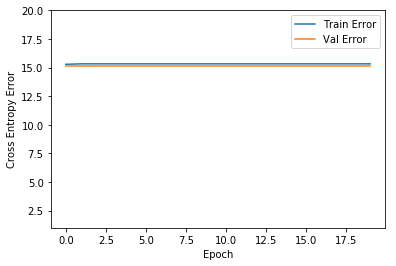

In [19]:
# Plot metrics
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Error')
    plt.plot(hist['epoch'], hist['categorical_crossentropy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_categorical_crossentropy'],
           label = 'Val Error')
    plt.ylim([1,20])
    plt.legend()
    plt.show()
    
plot_history(nn_history)

In [17]:
# See accuracy
hist = pd.DataFrame(nn_history.history)
accuracy_vec = hist.pop("acc")
finalAcc = accuracy_vec[len(accuracy_vec) - 1]
print("Final accuracy: {}%".format(finalAcc*100))

Final accuracy: 4.911111295223236%
